The workbook [spooky_lda](./spooky_lda.ipynb) made a naive Bayes model based on word frequency usage. This ended up with a ~94% accuracy score as measured on the training data alone.

This workbook looks at applying a topic model, and then clustering in the topic space. We also start by splitting into a training and test set first!

In [1]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
import matplotlib.pyplot as plt
import nltk
import pandas as pd

%matplotlib inline

plt.style.use('ggplot')

In [2]:
documents = pd.read_csv('./data/train.csv')

## Train / test split

Let's split our data into test/train splits, and vectorize the output. We won't apply stopwords, as the usage of articles may be useful in detecting different writing styles.

In [8]:
mask = np.random.random(size=len(documents)) < 0.8
train= documents[mask]
test = documents[~mask]

In [21]:
train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [9]:
len(train), len(test)

(15690, 3889)

In [11]:
count_vectorizer = CountVectorizer()
cv_data = count_vectorizer.fit_transform(train['text'])

In [12]:
cv_data

<15690x22969 sparse matrix of type '<class 'numpy.int64'>'
	with 344688 stored elements in Compressed Sparse Row format>

In [14]:
count_vectorizer.stop_words_

set()

In [15]:
cv_data.shape

(15690, 22969)

In [17]:
from sklearn.decomposition import TruncatedSVD

lsa = TruncatedSVD(n_components=10)
lsa_cv_data = lsa.fit_transform(cv_data)

In [19]:
lsa_cv_data.shape

(15690, 10)

In [31]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

for k in range(3,20):
    km = KMeans()
    km.fit(lsa_cv_data)
    cluster_labels = km.predict(lsa_cv_data)
    s_score = silhouette_score(lsa_cv_data, cluster_labels)
    print("k={}, score = {:8.6f}".format(k,score))

k=3, score = 0.156140
k=4, score = 0.177325
k=5, score = 0.169694
k=6, score = 0.169239
k=7, score = 0.164428
k=8, score = 0.177176
k=9, score = 0.162819
k=10, score = 0.161761
k=11, score = 0.156258
k=12, score = 0.164213
k=13, score = 0.165719
k=14, score = 0.157403
k=15, score = 0.159739
k=16, score = 0.163857
k=17, score = 0.157369
k=18, score = 0.169740
k=19, score = 0.163544


In [37]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30.0, verbose=1)

X_2 = tsne.fit_transform(lsa_cv_data)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 15690 samples in 0.015s...
[t-SNE] Computed neighbors for 15690 samples in 2.902s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15690
[t-SNE] Computed conditional probabilities for sample 2000 / 15690
[t-SNE] Computed conditional probabilities for sample 3000 / 15690
[t-SNE] Computed conditional probabilities for sample 4000 / 15690
[t-SNE] Computed conditional probabilities for sample 5000 / 15690
[t-SNE] Computed conditional probabilities for sample 6000 / 15690
[t-SNE] Computed conditional probabilities for sample 7000 / 15690
[t-SNE] Computed conditional probabilities for sample 8000 / 15690
[t-SNE] Computed conditional probabilities for sample 9000 / 15690
[t-SNE] Computed conditional probabilities for sample 10000 / 15690
[t-SNE] Computed conditional probabilities for sample 11000 / 15690
[t-SNE] Computed conditional probabilities for sample 12000 / 15690
[t-SNE] Computed conditional probabilities for sam

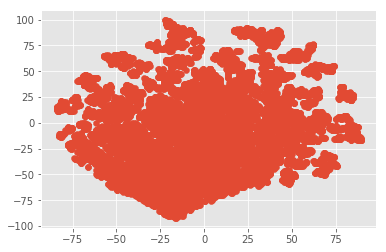

In [41]:
plt.scatter(X_2[:,0], X_2[:,1])

In [71]:
%%time
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV


svm = SVC()
params = {
    'C': [30, 100, 300],
    'gamma': [1e-3, 1e-2, 1e-1, 1]
}

grid = GridSearchCV(svm, params)
grid.fit(lsa_cv_data, train['author'].values)

#svm = SVC(C=1.0, gamma = 1.0)
#svm.fit(lsa_cv_data, train['author'].values)
#author_labels = svm.predict(lsa_cv_data)

CPU times: user 8min 28s, sys: 7.7 s, total: 8min 35s
Wall time: 8min 39s


In [72]:
grid.best_score_, grid.param_grid

(0.5192479286169535, {'C': [30, 100, 300], 'gamma': [0.001, 0.01, 0.1, 1]})

In [73]:
grid.best_params_

{'C': 100, 'gamma': 0.01}

In [74]:
%%time
# Let's try on the word matrix directly
params_matrix = {
    'C': [0.05, 1, 30, 100],
    'gamma': [1e-6, 1e-3, 1.0, 10]
}

grid_word_matrix = GridSearchCV(svm, params_matrix)
grid_word_matrix.fit(cv_data, train['author'])

CPU times: user 47min 22s, sys: 18.3 s, total: 47min 40s
Wall time: 48min 18s


In [76]:
grid_word_matrix.best_score_

0.7860420650095602

In [77]:
grid_word_matrix.best_params_

{'C': 100, 'gamma': 0.001}

### Now score on the test set

In [78]:
cv_test_data = count_vectorizer.transform(test['text'])
grid_word_matrix.score(cv_test_data, test['author'])

0.8066340961686809

i.e. a simple SVM will identify the correct author about 80% of the time.

Ideas for extensions:
- remove stop words?
- look at bigrams and trigrams?
- limit features?
- look at random forest on top of topic models?
- experiment with different number of topics?